<a href="https://colab.research.google.com/github/joshiayush/tscore/blob/main/notebooks/tscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

In [75]:
pd.set_option("display.max_colwidth", 200)

In [76]:
tscore_df = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/tscore/datasets/twitter_sentiment_analysis_dataset.csv",
    encoding="ISO-8859-1",
)
tscore_df.set_index('ItemID', inplace=True)

In [77]:
tscore_df.head(10)

,Sentiment,SentimentText
ItemID,,
1,0,is so sad for my APL friend.............
2,0,I missed the New Moon trailer...
3,1,omg its already 7:30 :O
4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
5,0,i think mi bf is cheating on me!!! T_T
6,0,or i just worry too much?
7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,0,Sunny Again Work Tomorrow :-| TV Tonight
9,1,handed in my uniform today . i miss you already


In [78]:
tscore_df.shape

(1048575, 2)

In [79]:
tscore_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 1 to 1048588
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Sentiment      1048575 non-null  int64 
 1   SentimentText  1048575 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.0+ MB


In [80]:
tscore_df['Sentiment'].unique()

array([0, 1])

Below is the proportion shared by the `positive` and `negative` sentiments in the dataset.

In [81]:
tscore_df['Sentiment'].value_counts(normalize=True)

1    0.528784
0    0.471216
Name: Sentiment, dtype: float64

## Data Visualization of `Sentiments`

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

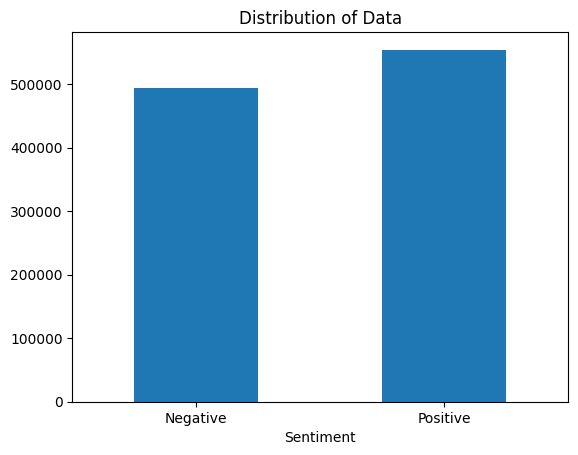

In [82]:
ax = (
    tscore_df.groupby("Sentiment")
    .count()
    .plot(kind="bar", title="Distribution of Data", legend=False)
)
ax.set_xticklabels(["Negative", "Positive"], rotation=0)

<Axes: xlabel='Sentiment', ylabel='count'>

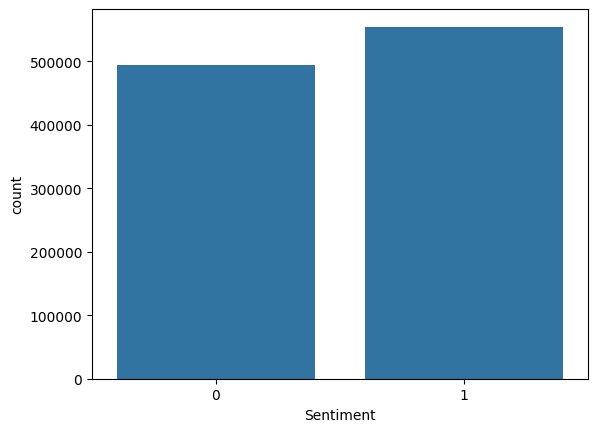

In [83]:
sns.countplot(x='Sentiment', data=tscore_df)

## Data Preprocessing

In [84]:
_STOP_WORDS = set(["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",])

In [85]:
class BasePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    @staticmethod
    def _clean_punctuations(text):
        # try the following to preserve separation between different words
        translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        return text.translate(translator)

    @staticmethod
    def _clean_repeating_chars(text):
        return re.sub(r'(.)1+', r'1', text)

    @staticmethod
    def _remove_mentioned(text):
        return re.sub(r'@[A-Za-z0-9]+', '', text)

    @staticmethod
    def _clean_urls(text):
        return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

    @staticmethod
    def _clean_numeric_chars(text):
        return re.sub('[0-9]+', '', text)

In [86]:
class TextCleaner(BasePreprocessor):
    def _clean_text(self, text):
        text = text.lower()
        text = self._clean_repeating_chars(text)
        text = self._remove_mentioned(text)
        text = self._clean_urls(text)
        text = self._clean_punctuations(text)
        text = self._clean_numeric_chars(text)
        return text

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._clean_text)
        return X

In [87]:
class WordTokenizer(BasePreprocessor):
    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(word_tokenize)
        return X

In [88]:
class WordStemmer(BasePreprocessor):
    @staticmethod
    def _stem_text(tokens):
        stemmer = nltk.PorterStemmer()
        return [stemmer.stem(word) for word in tokens]

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._stem_text)
        return X

In [89]:
class WordLemmatizer(BasePreprocessor):
    @staticmethod
    def _lemmatize_text(tokens):
        lemmatizer = nltk.WordNetLemmatizer()
        return [lemmatizer.lemmatize(word) for word in tokens]

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._lemmatize_text)
        return X

In [90]:
class StopWordsRemover(BasePreprocessor):
    @staticmethod
    def _clean_stop_words(tokens):
        return [word for word in tokens if word not in _STOP_WORDS]

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(self._clean_stop_words)
        return X

In [91]:
class JoinTokens(BasePreprocessor):
    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = X[column].apply(lambda tokens : " ".join(tokens))
        return X

In [92]:
pipeline = Pipeline(
    steps=[
        ("text_cleaner", TextCleaner(columns=["SentimentText"])),
        ("word_tokenizer", WordTokenizer(columns=["SentimentText"])),
        ("word_stemmer", WordStemmer(columns=["SentimentText"])),
        ("word_lemmatizer", WordLemmatizer(columns=["SentimentText"])),
        ("stop_words_remover", StopWordsRemover(columns=["SentimentText"])),
        ("join_tokens", JoinTokens(columns=["SentimentText"])),
    ]
)

In [93]:
tscore_df = pipeline.transform(tscore_df)

In [94]:
tscore_df.head(10)

,Sentiment,SentimentText
ItemID,,
1,0,sad apl friend
2,0,moon trailer
3,1,omg alreadi
4,0,omgaga sooo gunna cri thi dentist sinc supos crown min
5,0,mi bf cheat
6,0,worri
7,1,juuuuuuuuuuuuuuuuussssst chillin
8,0,sunni work tomorrow tonight
9,1,hand uniform today alreadi


## Data Visualization

In [95]:
vocabulary = []
for row in tscore_df['SentimentText']:
    vocabulary.extend(row.split())

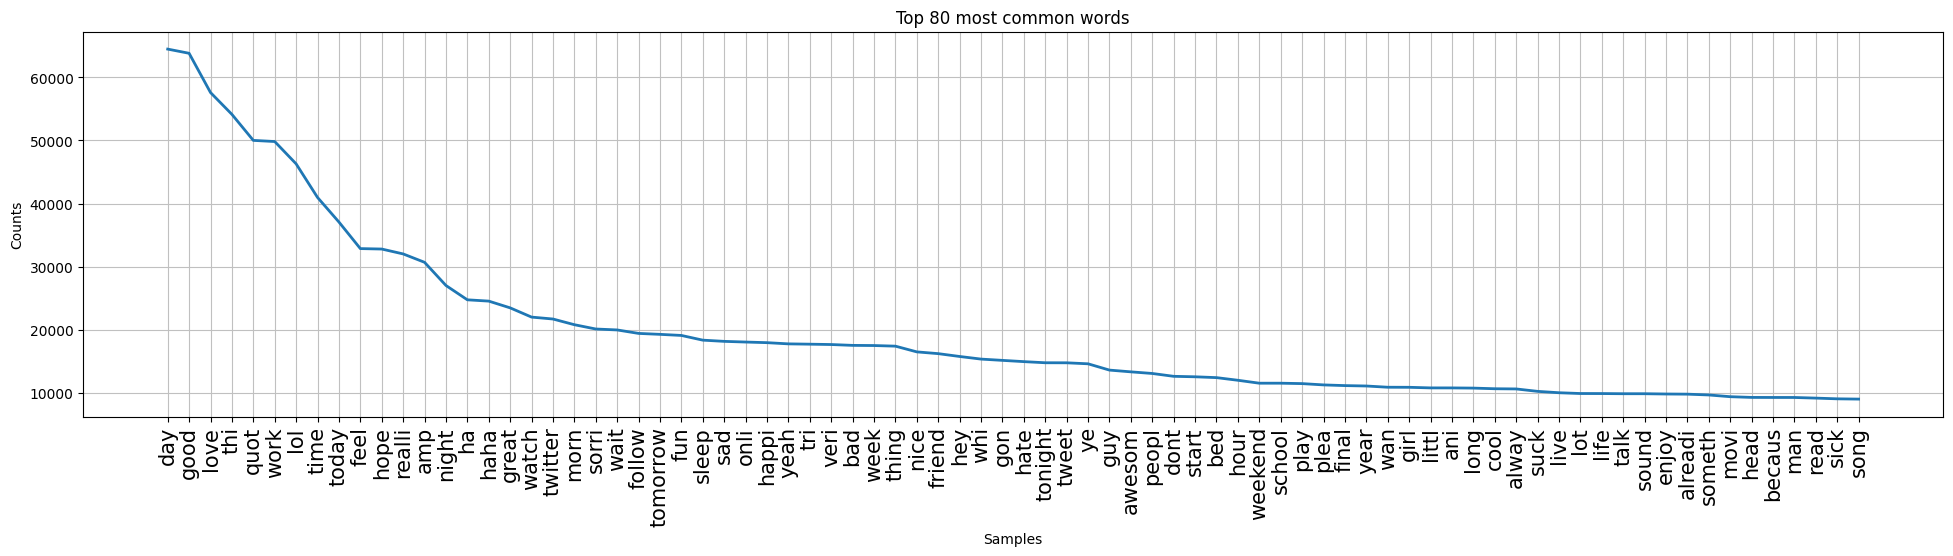

In [96]:
freq_dist = nltk.FreqDist(vocabulary)

plt.figure(figsize=(24, 5))
plt.title('Top 80 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(80, cumulative=False)
plt.show()

## Train/Test Split

In [104]:
X, y = tscore_df["SentimentText"], tscore_df["Sentiment"]

In [105]:
X_train, X_test, y_train, y_test = [], [], [], []

for train_idx, test_idx in StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=0
).split(X, y):
    X_train.append(X.iloc[train_idx])
    X_test.append(X.iloc[test_idx])
    y_train.append(y.iloc[train_idx])
    y_test.append(y.iloc[test_idx])

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [106]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), min_df=20, max_features=None)
vectoriser.fit(X)

TfidfVectorizer(min_df=30, ngram_range=(1, 2))

In [107]:
len(vectoriser.get_feature_names_out())

21053

In [108]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Model

In [109]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=0.9, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=0.9, max_iter=1000, penalty='l1', solver='liblinear')

In [110]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.7543261092434971, 0.7444722599718666)